### Задание
Обучить модель на датасете с буквами

### Анализ
Будут использоваться следующие техники:
- Сверточная архитектура
- Аугментация данных
- Label smoothing
- Динамическое изменение скорости обучения
- Weight decay
- BatchNorm2d, Dropout

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2

In [2]:
base_dir = './notMNIST_small'

In [3]:
os.listdir(f'{base_dir}/A')[:5]

['RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUub3Rm.png',
 'RmF2b3JpdC50dGY=.png',
 'RWxlbWVudGFTeW1ib2wtQm9sZEl0YWxpYy5vdGY=.png',
 'RXJpYyBCbGFjay50dGY=.png',
 'R2FyYW1vbmRQcmVtclByby1NZWRTdWJoLm90Zg==.png']

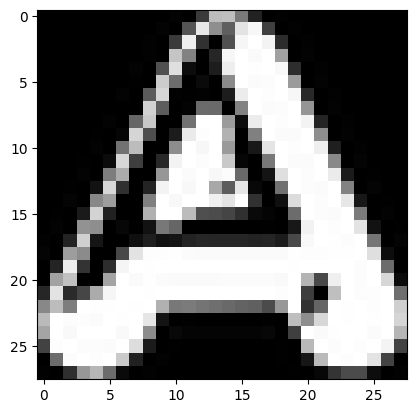

In [4]:
img = cv2.imread("./notMNIST_small/A/Q2FwdGFpbiBTaGluZXIudHRm.png")
plt.imshow(img)
plt.show()

In [5]:
folders = 'ABCDEFGHIJ'    # имеющиеся буквы
for folder in folders:
  print(f"total {folder} images: {len(os.listdir(f'{base_dir}/{folder}'))}")    # смотрим количество данных каждого класса

total A images: 1873
total B images: 1873
total C images: 1873
total D images: 1873
total E images: 1873
total F images: 1873
total G images: 1872
total H images: 1872
total I images: 1872
total J images: 1872


In [6]:
imgs = []
labels = []
for folder in folders:    # каждая папка с буквами
  for img in os.listdir(base_dir + f"/{folder}"):   # каждая буква
    if img.endswith('.png'):    # только png
      try:    # если удалось прочитать 
        #imgs.append(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0])   # добавляем изображение
        if not np.all(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0] ==cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0][0]):
            imgs.append(cv2.imread(base_dir + f"/{folder}/{img}")[:, :, 0])
            labels.append(folder)   # добавляем метку класса
      except:   # если возникла ошибка при чтении
        print(base_dir + f"/{folder}/{img}")     # выводим название изображение, которое не удалось прочитать
        continue
imgs = np.array(imgs).astype('float32')/255.    # масштабируем признаки

./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [7]:
def to_categorical(labels):
  """
  This function convert the latter into a categorical shape(view)
  labels: this param consists of the letters which will convert
  Example: labels -> ['A', 'B'] -> [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]] 
  """
  categories = 'ABCDEFGHIJ'
  new_labels = np.zeros(shape=(len(labels), len(categories)))
  for i, label in enumerate(labels):
    new_labels[i][categories.find(label)] = 1 
  return new_labels

A
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


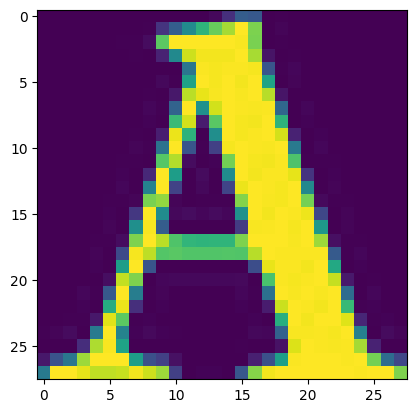

In [8]:
print(labels[0])    # выводим пример изображения с меткой
labels = to_categorical(labels)
plt.imshow(imgs[0])
print(labels[0])

In [9]:
indices = np.arange(labels.shape[0])    # перемешиваем данные
np.random.shuffle(indices)
imgs = imgs[indices]
labels = labels[indices]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


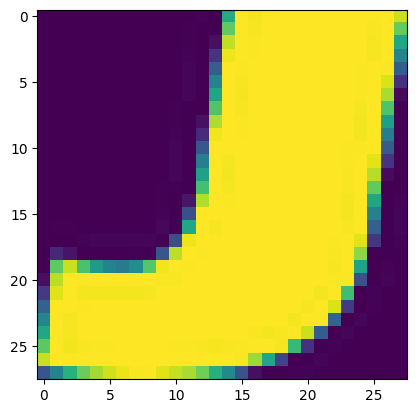

In [10]:
plt.imshow(imgs[0])
print(labels[0])

In [11]:
print("Images shape: ", imgs.shape)   # выводим размеры датасета
print("Labels shape: ", labels.shape)

Images shape:  (18442, 28, 28)
Labels shape:  (18442, 10)


In [12]:
# разбиваем на тестовую и тренировочную выборку
test_imgs = imgs[:500]
test_labels = labels[:500]
train_imgs = imgs[500:]
train_labels = labels[500:]
print("Train images shape: ", train_imgs.shape)
print("Test images shape: ", test_imgs.shape)
print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train images shape:  (17942, 28, 28)
Test images shape:  (500, 28, 28)
Train labels shape:  (17942, 10)
Test labels shape:  (500, 10)


Создание CNN модели

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CNN_net(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Создание загрузчиков датасетов с аугментацией

In [14]:
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = TensorDataset(torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1), torch.tensor(train_labels, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_imgs, dtype=torch.float32).unsqueeze(1), torch.tensor(test_labels, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=32)

Определение параметров обучения и вывод иформации о модели

In [15]:
model = CNN_net(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_net                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 28, 28]           64
│    └─GELU: 2-3                         [1, 32, 28, 28]           --
│    └─Conv2d: 2-4                       [1, 64, 28, 28]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 28, 28]           128
│    └─GELU: 2-6                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-7                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-8                       [1, 128, 14, 14]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 14, 14]          256
│    └─GELU: 2-10                        [1, 128, 14, 14]          --
│    └─Conv2d: 2-11                      [1, 256, 14, 14]          295,168

Определение функций обучения и инференса модели

In [16]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

def evaluate(model, test_loader, criterion, epoch):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Loss: {running_loss / len(test_loader)}, Accuracy: {100 * correct / total}%, Epoch: {epoch}")

Обучение модели

In [17]:
num_epochs = 40
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, criterion, optimizer)
    scheduler.step()
    evaluate(model, test_loader, criterion, epoch)

Test Loss: 0.7225301712751389, Accuracy: 93.4%, Epoch: 1
Test Loss: 0.6750679910182953, Accuracy: 94.0%, Epoch: 2
Test Loss: 0.6436007916927338, Accuracy: 96.0%, Epoch: 3
Test Loss: 0.6329025849699974, Accuracy: 96.4%, Epoch: 4
Test Loss: 0.6239566802978516, Accuracy: 96.4%, Epoch: 5
Test Loss: 0.6212677583098412, Accuracy: 95.8%, Epoch: 6
Test Loss: 0.6116872057318687, Accuracy: 95.6%, Epoch: 7
Test Loss: 0.6065933182835579, Accuracy: 96.0%, Epoch: 8
Test Loss: 0.6043331474065781, Accuracy: 96.6%, Epoch: 9
Test Loss: 0.6021736785769463, Accuracy: 96.6%, Epoch: 10
Test Loss: 0.6010017544031143, Accuracy: 96.6%, Epoch: 11
Test Loss: 0.6003563329577446, Accuracy: 96.4%, Epoch: 12
Test Loss: 0.5993868038058281, Accuracy: 96.0%, Epoch: 13
Test Loss: 0.5966645032167435, Accuracy: 96.6%, Epoch: 14
Test Loss: 0.5977922677993774, Accuracy: 96.6%, Epoch: 15
Test Loss: 0.5968212708830833, Accuracy: 96.4%, Epoch: 16
Test Loss: 0.5962347313761711, Accuracy: 96.6%, Epoch: 17
Test Loss: 0.5963958278

### Выводы
- Метод позволяет обучить модель с точностью до ~97.5%
- Использованы различные приемы для улучшения обучения: - Аугментация данных, Label smoothing, динамическое изменение скорости обучения, Weight decay, BatchNorm2d, Dropout